# Красивый код соревнование от Сбера в дисциплине data science

https://beautifulcode.sber.ru/task/data_science

**Цель соревнования:**

* Построить модель, которая на основании размеченных данных будет предсказывать качество пароля


In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
url = r'/content/drive/MyDrive/DATA/SBER/passwords.csv'
df = pd.read_csv(url)

## Описание данных

* password - пароль

* strength (target) - оценка пароля: 0 - слабый, 1 - средний, 2 - сильный. Целевая переменная

In [4]:
df.head(5)

,password,strength
0,yrtzuab476,1
1,yEdnN9jc1NgzkkBP,2
2,sarita99,1
3,Suramerica2015,2
4,PPRbMvDIxMQ19TMo,2


In [5]:
df.tail(5)

,password,strength
99995,aulona044,1
99996,5201314ding,1
99997,isaac19725,1
99998,toji25,0
99999,midnight000,1


## Исследование данных

Размер датасета

In [6]:
df.shape

(100000, 2)

Информация о типах данных и пропусках

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  100000 non-null  object
 1   strength  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [8]:
df.describe(include='object')

,password
count,100000
unique,100000
top,yrtzuab476
freq,1


Основные числовые характеристики

In [9]:
df['strength'].describe()

count    100000.000000
mean          0.988660
std           0.507044
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: strength, dtype: float64

Посмотрим на распределение оценок

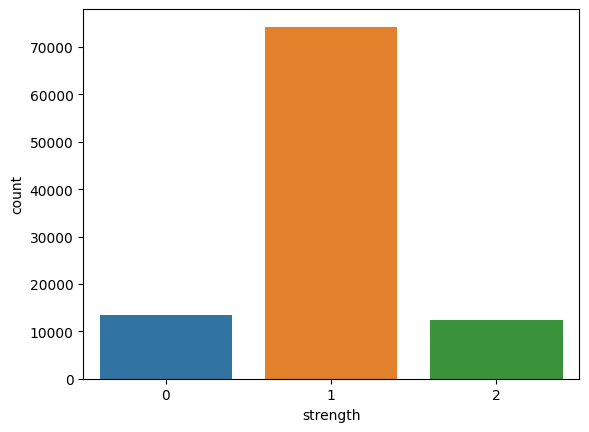

In [10]:
sns.countplot(x=df['strength'])
plt.show()

* В данных отсутствуют пропущенные значения
* Пароли все уникальные
* Аномалий в оценках класса пароля нет

## Добавление агрегированных признаков

In [11]:
from string import ascii_lowercase, ascii_uppercase, digits, punctuation

Функция подсчета символов изопределенного набора в пароле

In [12]:
def check(obj:str, sample:str)->int:
    out = 0
    for i in obj:
        if i in sample:
            out += 1
    return out

def checkNot(obj:str)->int:
            out = 0
            for i in obj:
                if i not in ascii_lowercase + ascii_uppercase + digits + punctuation:
                    out +=1
            return out

Функция рассчета энтропии

In [13]:
def getEntrop(password:str)->int:
    out = check(password, digits)
    out += check(password, ascii_uppercase)
    out += check(password, ascii_lowercase)
    out *= 5.9542
    out += (check(password, punctuation)+checkNot(password))*6.5699
    return int(out)

* Колличество строчных латинских букв в пароле

In [14]:
df['lowCount'] = df['password'].map(lambda x:check(x, ascii_lowercase))

* Колличество уникальных строчных латинских букв в пароле

In [15]:
df['UniqLowCount'] = df['password'].map(lambda x:check(set(x), ascii_lowercase))

* Колличество заглавных латинских букв в пароле

In [16]:
df['upCount'] = df['password'].map(lambda x:check(x, ascii_uppercase))

* Колличество уникальных заглавных латинских букв в пароле

In [17]:
df['UniqUpCount'] = df['password'].map(lambda x:check(set(x), ascii_uppercase))

* Колличество цифр в пароле

In [18]:
df['digitCount'] = df['password'].map(lambda x:check(x, digits))

* Колличество уникальных цифр в пароле

In [19]:
df['UniqDigitCount'] = df['password'].map(lambda x:check(set(x), digits))

* Колличество специальных символов в пароле

In [20]:
df['symbolCount'] = df['password'].map(lambda x:check(x, punctuation))

* Колличество уникальных специальных символов в пароле

In [21]:
df['UniqSymbolCount'] = df['password'].map(lambda x:check(set(x), punctuation))

* Колличество всех остальных символов которые небыли проверены ранее в пароле

In [22]:
df['otherCount'] = df['password'].map(lambda x:checkNot(x))

* Колличество уникальных всех остальных символов которые небыли проверены ранее в пароле

In [23]:
df['UniqOtherCount'] = df['password'].map(lambda x:checkNot(set(x)))

* Длинна пароля

In [24]:
df['len'] = df['password'].map(lambda x:len(x))

* Колличество бит энтропии

In [25]:
df['entrop'] = df['password'].map(lambda x: getEntrop(x))

Получившийся датасет

In [26]:
df.head(5)

,password,strength,lowCount,UniqLowCount,upCount,UniqUpCount,digitCount,UniqDigitCount,symbolCount,UniqSymbolCount,otherCount,UniqOtherCount,len,entrop
0,yrtzuab476,1,7,7,0,0,3,3,0,0,0,0,10,59
1,yEdnN9jc1NgzkkBP,2,9,8,5,4,2,2,0,0,0,0,16,95
2,sarita99,1,6,5,0,0,2,1,0,0,0,0,8,47
3,Suramerica2015,2,9,7,1,1,4,4,0,0,0,0,14,83
4,PPRbMvDIxMQ19TMo,2,4,4,10,7,2,2,0,0,0,0,16,95


## Рассчитаем корреляцию Пирсона между целевой переменной и полученными агрегированными признаками

In [27]:
from statistics import correlation

In [28]:
col = [i for i in df.columns if i not in ('password', 'strength')]
print('Коэффициент Пирсона между целевой переменной:')
koef = {}
for i in col:
    koef[i] = correlation(df['strength'], df[i])
out = list(koef.values())
out.sort(reverse=True)
for i in out:
    for j in koef.keys():
        if koef[j] == i:
            print(f'{j} = {i}')


Коэффициент Пирсона между целевой переменной:
len = 0.8467898548958538
entrop = 0.8464627870103256
UniqUpCount = 0.6237191038060655
upCount = 0.6207212473146796
lowCount = 0.22220348217750505
UniqLowCount = 0.20000228066390013
UniqDigitCount = 0.19885431738640538
digitCount = 0.1782240220804091
UniqSymbolCount = 0.1567852127523305
symbolCount = 0.14864483963965375
otherCount = 0.01042389103990635
UniqOtherCount = 1.7830367009364316e-05


Из полученных коэффициентов Пирсона видно, что имеется высокая положительная корреляция между целевой переменной и длинной пароля, а также бит энтропии. А также средняя положительная корреляция между целевой переменной и количества заглавных латинских букв и количества уникальных латинских заглавных букв. Остальные агрегированные признаки имеют слабую положительную корреляцию с целевой переменной.

# Графики

Тепловая карта кореляции между целевой переменной и агрегированными данными

<Axes: >

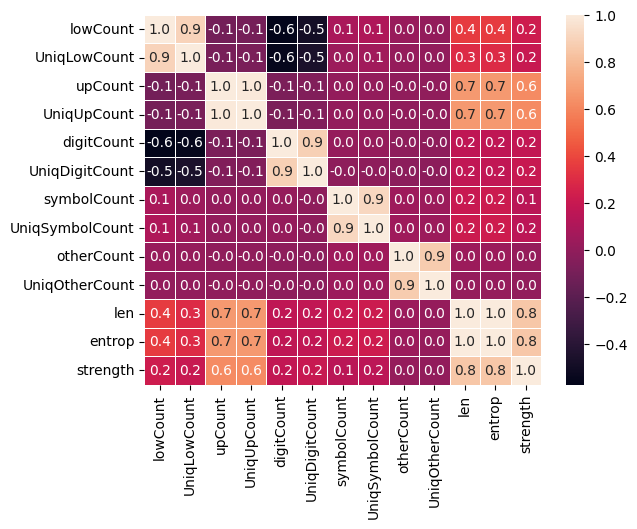

In [29]:
col += ['strength']
sns.heatmap(df[col].corr(), annot=True, fmt=".1f", linewidth=.5)

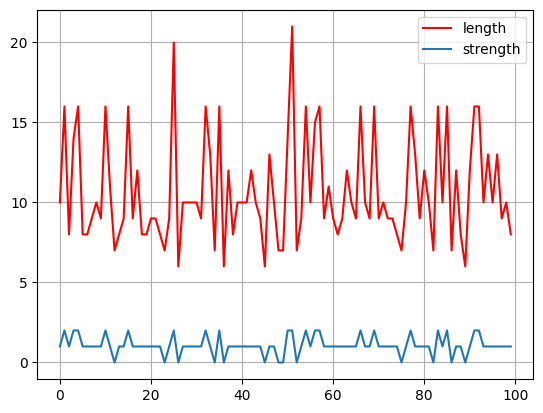

In [30]:
plt.plot(df['len'][:100], "r", label="length")
plt.plot(df['strength'][:100], label="strength")
plt.grid(True)
plt.legend(loc="best")
plt.autoscale()

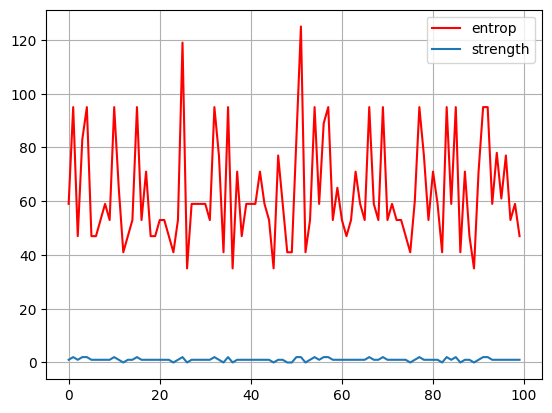

In [31]:
plt.plot(df['entrop'][:100], "r", label="entrop")
plt.plot(df['strength'][:100], label="strength")
plt.grid(True)
plt.legend(loc="best")
plt.autoscale()

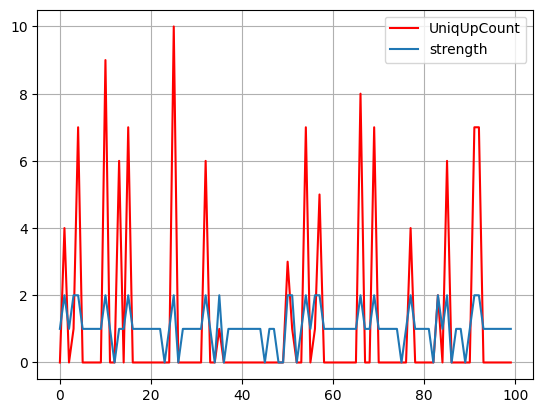

In [32]:
plt.plot(df['UniqUpCount'][:100], "r", label="UniqUpCount")
plt.plot(df['strength'][:100], label="strength")
plt.grid(True)
plt.legend(loc="best")
plt.autoscale()

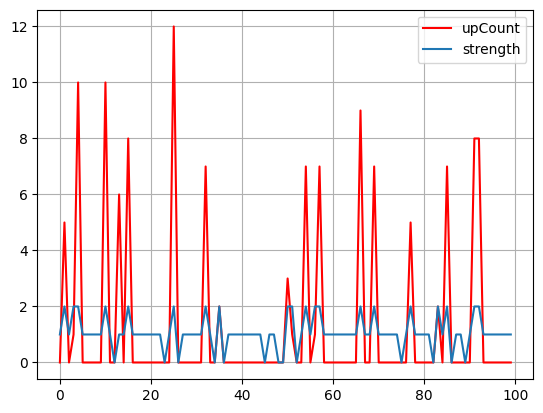

In [33]:
plt.plot(df['upCount'][:100], "r", label="upCount")
plt.plot(df['strength'][:100], label="strength")
plt.grid(True)
plt.legend(loc="best")
plt.autoscale()

Диапазон значения агрегированного признака длинна пароля для каждого класса целевой переменной

In [34]:
for i in range(3):
    col = df.loc[df['strength'].isin([i])]
    print('Класс', i, end=': ')
    print('min =', min(col['len']), 'max =', max(col['len']))

Класс 0: min = 1 max = 7
Класс 1: min = 8 max = 13
Класс 2: min = 14 max = 45


Диапазон значения агрегированного признака энтропии для каждого класса целевой переменной

In [35]:
for i in range(3):
    col = df.loc[df['strength'].isin([i])]
    print('Класс', i, end=': ')
    print('min =', min(col['entrop']), 'max =', max(col['entrop']))

Класс 0: min = 5 max = 45
Класс 1: min = 47 max = 81
Класс 2: min = 83 max = 271


Диапазон значения агрегированного признака уникальные заглавные буквы латинского алфавита для каждого класса целевой переменной

In [36]:
for i in range(3):
    col = df.loc[df['strength'].isin([i])]
    print('Класс', i, end=': ')
    print('min =', min(col['UniqUpCount']), 'max =', max(col['UniqUpCount']))

Класс 0: min = 0 max = 6
Класс 1: min = 0 max = 10
Класс 2: min = 0 max = 15


Диапазон значения агрегированного признака заглавные буквы латинского алфавита для каждого класса целевой переменной

In [37]:
for i in range(3):
    col = df.loc[df['strength'].isin([i])]
    print('Класс', i, end=': ')
    print('min =', min(col['upCount']), 'max =', max(col['upCount']))

Класс 0: min = 0 max = 6
Класс 1: min = 0 max = 12
Класс 2: min = 0 max = 19


# Построение модели

Из полученных данных диапазона значений длинны пароля, а также количества энтропии для каждого класса пароля можно увидеть четкое однозначное разделения на три класса.

Разобьем датасет на тренировочную и тестовую выборку

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [39]:
dataMetr = pd.DataFrame()
xCol = [i for i in df.columns if i not in ('strength')]
yCol = 'strength'
x_train, x_test, y_train, y_test = train_test_split(df[xCol],
                                                    df[yCol],
                                                    test_size=0.25,
                                                    random_state=1024)
dataMetr['strength'] = y_test


In [40]:
import pickle

In [41]:
def saveModel(model, name:str)->None:
    urlMod = r'/content/drive/MyDrive/DATA/SBER/model/'
    with open(urlMod+name+'.pickle', 'wb') as file:
        pickle.dump(model, file)

## Классификатор построенный на основыве сведений о длине пароля

In [42]:
def checkLenPassword(password:str)->int:
    if len(password) == 0:
        raise ValueError('Пароль не должен быть пустым')
    if 0 < len(password) <= 7:
        return 0
    elif 8 <= len(password) <= 13:
        return 1
    elif 14 <= len(password):
        return 2


Проверим классификатор на тестовой выборке

In [45]:
dataMetr['chkLen'] = x_test['password'].map(checkLenPassword)

In [46]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(dataMetr['strength'], dataMetr['chkLen'], target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      3324
     class 1       1.00      1.00      1.00     18607
     class 2       1.00      1.00      1.00      3069

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



## Классификатор построенный на основыве сведений о энтропии пароля

In [47]:
def checkEntropPassword(password:str)->int:
    dataEntrop = getEntrop(password)
    if len(password) == 0:
        raise ValueError('Пароль не должен быть пустым')
    if dataEntrop < 47:
        return 0
    elif 47 <= dataEntrop <= 82:
        return 1
    elif dataEntrop >= 83:
        return 2


Проверим классификатор на тестовой выборке

In [48]:
dataMetr['chkEnt'] = x_test['password'].map(checkEntropPassword)

In [49]:
print(classification_report(dataMetr['strength'], dataMetr['chkEnt'], target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      3324
     class 1       1.00      1.00      1.00     18607
     class 2       1.00      1.00      1.00      3069

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



## Логистическая регрессия

Данный метод входит в топ часто используемых алгоритмов. Данный метод обладает следующими свойствами - простота, скорость, наглядность. Алгоритм решения newton-cg выбран, потому что он имеет следующие преимущества:
 эффективен т.к. он быстрее сходится чем, к примеру метод

*   Эффективность: быстрее сходится чем, по сравнению с некоторыми другими методами например методом Ньютона.
*   Масштабируемость: хорошо работает с задачами высокой размерности.
*   Глобальная сходимость: данный метод может гарантировать глобальную сходимость по сравнению с некоторыми другими методами к примеру все того же метода Ньютона.

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
lrModel = LogisticRegression( solver='newton-cg', random_state=1024, max_iter=150)
xCol = ['len', 'entrop', 'UniqUpCount', 'upCount']

In [54]:
%time lrModel.fit(x_train[xCol], y_train)

CPU times: user 14.6 s, sys: 9.35 s, total: 24 s
Wall time: 16.6 s


LogisticRegression(max_iter=150, random_state=1024, solver='newton-cg')

In [55]:
dataMetr['lr'] = lrModel.predict(x_test[xCol])

In [56]:
print(classification_report(dataMetr['strength'], dataMetr['lr'], target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      3324
     class 1       1.00      1.00      1.00     18607
     class 2       1.00      1.00      1.00      3069

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



Сохранить обученную модель

In [57]:
saveModel(lrModel, 'lrModel')

Коэффициенты для каждого класса

In [58]:
nameCol = ['len', 'entrop', 'UniqUpCount', 'upCount']
for i in range(3):
    print('Класс', i)
    for j, val in enumerate(nameCol):
        print(f'\t{val}: {lrModel.coef_[0][j]}')

Класс 0
	len: -1.4449235316018367
	entrop: -3.100422805024245
	UniqUpCount: -0.0796127081759486
	upCount: -0.08706815552892301
Класс 1
	len: -1.4449235316018367
	entrop: -3.100422805024245
	UniqUpCount: -0.0796127081759486
	upCount: -0.08706815552892301
Класс 2
	len: -1.4449235316018367
	entrop: -3.100422805024245
	UniqUpCount: -0.0796127081759486
	upCount: -0.08706815552892301


Из значений коэффициентов видно что основной вклад внесли значения длинны пароля и энтропии

## Метод опорных векторов

Метод опорных векторов представляет собой мощный и гибкий инструмент для мультиклассовой классификации, и его преимущества включают эффективность, хорошую обобщающую способность, работу с нелинейными данными, устойчивость к выбросам и возможность работы с высокоразмерными данными.

В качестве функции ядра выбрана функция RBF данная функция является функцией по умолчанию и имеет следующие преимущества:


*    Работа с нелинейными данными: позволяет модели строить нелинейные разделяющие поверхности.
*    Гибкость: позволяет модели адаптироваться к различным типам данных.
*   Универсальность:  может аппроксимировать любую непрерывную функцию.
*   Устойчивость к выбросам: обладает свойством гладкости и глобальной определенности, что в свою очередьделает модель устойчивой к выбросам в данных и помогает предотвратить переобучение.
*    Высокая точность: демонстрирует высокую точность классификации. Может обеспечить хорошую разделимость классов и хорошую обобщающую способность модели.




In [59]:
from sklearn.svm import SVC

In [ ]:
svcModel = SVC(kernel='rbf')

In [61]:
%time svcModel.fit(x_train[xCol], y_train)

CPU times: user 1.07 s, sys: 69.8 ms, total: 1.14 s
Wall time: 1.16 s


SVC()

In [62]:
dataMetr['svc'] = svcModel.predict(x_test[xCol])

In [63]:
print(classification_report(dataMetr['strength'], dataMetr['svc'], target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      3324
     class 1       1.00      1.00      1.00     18607
     class 2       1.00      1.00      1.00      3069

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



Сохранить обученную модель

In [64]:
saveModel(svcModel, 'svcModel')

## Градиентный бустинг

Преимущества градиентного бустинга:
*	Высокая точность: обеспечивает высокую точность предсказаний.
*	Работа с большими наборами данных: Градиентный бустинг может эффективно работать с большими наборами данных.
*	Устойчивость к переобучению: Градиентный бустинг использует методы регуляризации. Это помогает предотвратить переобучение модели и улучшить ее обобщающую способность.


In [65]:
from catboost import CatBoostClassifier

In [66]:
boostModel = CatBoostClassifier(iterations=200,
                           learning_rate=0.01,
                           random_state=1024,
                           verbose=False)


In [67]:
%time boostModel.fit(x_train[xCol], y_train)

CPU times: user 8.89 s, sys: 119 ms, total: 9.01 s
Wall time: 4.83 s


In [68]:
dataMetr['boost'] = boostModel.predict(x_test[xCol])

In [69]:
urlMod = r'/content/drive/MyDrive/DATA/SBER/model/'
boostModel.save_model(urlMod+'boostModel.cbm', format="cbm")

In [70]:
print(classification_report(dataMetr['strength'], dataMetr['boost'], target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      3324
     class 1       1.00      1.00      1.00     18607
     class 2       1.00      1.00      1.00      3069

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



# Выводы

Из полученных данных метрик моделей классификаторов видно, что все модели имеют 100% точность на тестовой выборке. Строить ансамбль моделей обучения в этом случае не имеет смысла т.к. это ничего не даст. Оценить модели можно только по времени обучения и по затраченым ресурсам. Логистическая регрессия 16 сек., метод опрорных векторов 1 сек., градиентный бустинг 4 сек. Значений по умолчанию методов машинного обучения, которые использовались достаточно. Применять средства для подбора гиперпараметров типа Optuna моделей нет необходимости т.к. повысить точность не получится.